In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!ls /content/gdrive/MyDrive/DeepLearning/Covid19/dataset
cp = '/content/gdrive/MyDrive/DeepLearning/Covid19/dataset'

all  part


In [3]:
import pandas as pd
import numpy as np

In [4]:
data_all_origin = pd.read_csv(cp + '/all/covid19_20210531_all.csv')
data_part_origin = pd.read_csv(cp + '/part/covid19_20210531_part.csv')

In [5]:
data_all = data_all_origin.drop(['Unnamed: 0'], axis = 1)
data_part = data_part_origin.drop(['Unnamed: 0'], axis = 1)

# 전국 데이터만으로 예측
# 데이터 갯수가 매우 적음

In [6]:
data_all

#   속성 설명(all)
#   DECIDE_CNT          누적 확진자수
#   CLEAR_CNT           누적 격리해제 수
#   EXAM_CNT            검사진행 수
#   DEATH_CNT           누적 사망자 수
#   CARE_CNT            치료중 환자 수
#   RESULT_NEG_CNT      결과 음성 수
#   ACC_EXAM_CNT        누적 검사 수
#   ACC_EXAM_COMP_CNT   누적 검사 완료 수
#   ACC_DEF_RATE        누적 확진률
#   CREATE_DT           등록일시분초
#   UPDATE_DT           수정일시분

,accDefRate,accExamCnt,accExamCompCnt,careCnt,clearCnt,createDt,deathCnt,decideCnt,examCnt,resutlNegCnt,seq,stateDt,stateTime,updateDt
0,NaN,NaN,NaN,NaN,1,47:33.3,0,0,1,NaN,1,20200101,18:00,21:56.6
1,NaN,NaN,NaN,NaN,1,47:33.3,0,0,1,NaN,1,20200201,18:00,47:33.3
2,NaN,NaN,NaN,NaN,2,22:49.5,2,2,2,NaN,2,20200202,9:00,22:49.5
3,NaN,NaN,NaN,NaN,0,41:17.2,0,15,0,NaN,3,20200203,9:00,41:17.2
4,NaN,NaN,NaN,NaN,0,26:59.6,0,0,0,NaN,4,20200204,0:00,26:59.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,1.449340,9665693.0,9543034.0,8188.0,128180,2021-05-27 09:39:43.099,1943,138311,122659,9404723.0,524,20210527,00:00,NaN
483,1.449938,9702456.0,9579584.0,8193.0,128759,2021-05-28 09:34:29.553,1946,138898,122872,9440686.0,525,20210528,00:00,2021-05-29 09:47:35.466
484,1.450925,9733591.0,9609801.0,7741.0,129739,2021-05-29 09:45:26.765,1951,139431,123790,9470370.0,526,20210529,00:00,NaN
485,1.454196,9747614.0,9621121.0,7572.0,130381,2021-05-30 09:24:39.384,1957,139910,126493,9481211.0,527,20210530,00:00,NaN


In [7]:
data_all = data_all.drop(['createDt', 'updateDt', 'seq', 'stateTime'], axis = 1)

infector = []
clear = []
infector.append(0)
clear.append(0)

for i in range(len(data_all) - 1):
    infector.append(data_all['decideCnt'][i + 1] - data_all['decideCnt'][i])
    clear.append(data_all['clearCnt'][i + 1] - data_all['clearCnt'][i])

infector = np.array(infector)
clear = np.array(clear)
infector = pd.DataFrame(infector)
clear = pd.DataFrame(clear)
infector.columns = ['infector']
clear.columns = ['clear']

data_all = data_all.assign(infector = infector)
data_all = data_all.assign(clear = clear)
data_all = data_all.dropna()
data_all = data_all.reset_index(drop = True)

data_all

,accDefRate,accExamCnt,accExamCompCnt,careCnt,clearCnt,deathCnt,decideCnt,examCnt,resutlNegCnt,stateDt,infector,clear
0,5.329140,125851.0,90296.0,4159.0,34,28,4812,35555,85484.0,20200303,600,3
1,4.919986,136707.0,108293.0,4750.0,41,32,5328,28414,102965.0,20200304,516,7
2,4.622748,146541.0,124731.0,5255.0,88,35,5766,21810,118965.0,20200305,438,47
3,4.397235,164740.0,142908.0,5643.0,108,42,6284,21832,136624.0,20200306,518,20
4,4.267543,178189.0,158569.0,6134.0,118,44,6767,19620,151802.0,20200307,483,10
...,...,...,...,...,...,...,...,...,...,...,...,...
450,1.449340,9665693.0,9543034.0,8188.0,128180,1943,138311,122659,9404723.0,20210527,637,606
451,1.449938,9702456.0,9579584.0,8193.0,128759,1946,138898,122872,9440686.0,20210528,587,579
452,1.450925,9733591.0,9609801.0,7741.0,129739,1951,139431,123790,9470370.0,20210529,533,980
453,1.454196,9747614.0,9621121.0,7572.0,130381,1957,139910,126493,9481211.0,20210530,479,642


In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler_combine = MinMaxScaler()
scaler_train = MinMaxScaler()
scaler_test = MinMaxScaler()

scale_combine_all = ['careCnt', 'examCnt', 'resutlNegCnt', 'clearCnt', 'infector']
scale_train_all = ['careCnt', 'examCnt', 'resutlNegCnt', 'clearCnt']
scale_test_all = ['infector']

scaled_combine_all = scaler_combine.fit_transform(data_all[scale_combine_all])
scaled_train_all = scaler_train.fit_transform(data_all[scale_train_all])
scaled_test_all = scaler_test.fit_transform(data_all[scale_test_all])

scaled_combine_all = pd.DataFrame(scaled_combine_all)
scaled_train_all = pd.DataFrame(scaled_train_all)
scaled_test_all = pd.DataFrame(scaled_test_all)

scaled_combine_all.columns = scale_combine_all
scaled_train_all.columns = scale_train_all
scaled_test_all.columns = scale_test_all

In [9]:
#train_all = scaled_combine_all[:len(scaled_combine_all) - 30]
#test_all = scaled_combine_all[len(scaled_combine_all) - 30:]
train_all = scaled_combine_all
test_all = scaled_combine_all

In [10]:
# make dataset
# find next 'end' data 
def make_dataset(data, label, window_size = 10):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i + window_size]))
        label_list.append(np.array(label.iloc[i + window_size]))
    return np.array(feature_list), np.array(label_list)
# dataset: (i ~ i + window_size)days feature_list and (i + window_size) label_list
# 10개의 데이터에 그 다음날 결과 값이 한 세트

In [11]:
train_feature_all = train_all[['careCnt', 'examCnt', 'resutlNegCnt', 'clearCnt']]
train_label_all = train_all[['infector']]
test_feature_all = test_all[['careCnt', 'examCnt', 'resutlNegCnt', 'clearCnt']]
test_label_all = test_all[['infector']]

In [12]:
train_label_all.shape

(455, 1)

In [13]:
# train dataset
train_feature_all, train_label_all = make_dataset(train_feature_all, train_label_all, 10)

train_feature_all.shape, train_label_all.shape

((445, 10, 4), (445, 1))

In [14]:
# test dataset
test_feature_all, test_label_all = make_dataset(test_feature_all, test_label_all, 10)

test_feature_all.shape, test_label_all.shape

((445, 10, 4), (445, 1))

In [15]:
from sklearn.model_selection import train_test_split

# build train, validation set
x_train, x_valid, y_train, y_valid = train_test_split(train_feature_all, train_label_all, test_size = 0.2)

x_train.shape, x_valid.shape

((356, 10, 4), (89, 10, 4))

In [16]:
from keras.models import *
from keras.layers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint


def build_model():
    model = Sequential()
    

    model.add(Bidirectional(LSTM(50, return_sequences = False), input_shape=(train_feature_all.shape[1], train_feature_all.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation = 'sigmoid'))
    model.add(Dense(1, activation = 'linear'))
    #model.add(Bidirectional(LSTM(64, return_sequences = True), input_shape=(train_feature_all.shape[1], train_feature_all.shape[2])))
    #model.add(Bidirectional(LSTM(32, return_sequences = False)))
    #model.add(Dense(1, activation = 'linear'))

    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100)               22000     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 28,529
Trainable params: 28,529
Non-trainable params: 0
_________________________________________________________________


In [17]:
# if val_loss will not imporve consecutive 10 times(patience = 10), epochs will be stopped
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)
mc = ModelCheckpoint('check.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only=True)

In [19]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adamax

model.compile(loss = 'mean_squared_error', optimizer = Adam(learning_rate = 0.0005), metrics = ['acc'])
history = model.fit(x_train, y_train, epochs = 1000, batch_size = 1, validation_data = (x_valid, y_valid), callbacks = [es, mc])

Epoch 1/1000
356/356 [==============================] - 7s 9ms/step - loss: 0.0209 - acc: 2.8863e-04 - val_loss: 0.0138 - val_acc: 0.0000e+00

Epoch 00001: val_acc improved from -inf to 0.00000, saving model to check.h5
Epoch 2/1000
356/356 [==============================] - 2s 5ms/step - loss: 0.0203 - acc: 0.0043 - val_loss: 0.0104 - val_acc: 0.0000e+00

Epoch 00002: val_acc did not improve from 0.00000
Epoch 3/1000
356/356 [==============================] - 2s 6ms/step - loss: 0.0145 - acc: 9.3001e-04 - val_loss: 0.0111 - val_acc: 0.0000e+00

Epoch 00003: val_acc did not improve from 0.00000
Epoch 4/1000
356/356 [==============================] - 2s 6ms/step - loss: 0.0117 - acc: 0.0027 - val_loss: 0.0072 - val_acc: 0.0000e+00

Epoch 00004: val_acc did not improve from 0.00000
Epoch 5/1000
356/356 [==============================] - 2s 5ms/step - loss: 0.0127 - acc: 0.0117 - val_loss: 0.0083 - val_acc: 0.0000e+00

Epoch 00005: val_acc did not improve from 0.00000
Epoch 6/1000
356/356

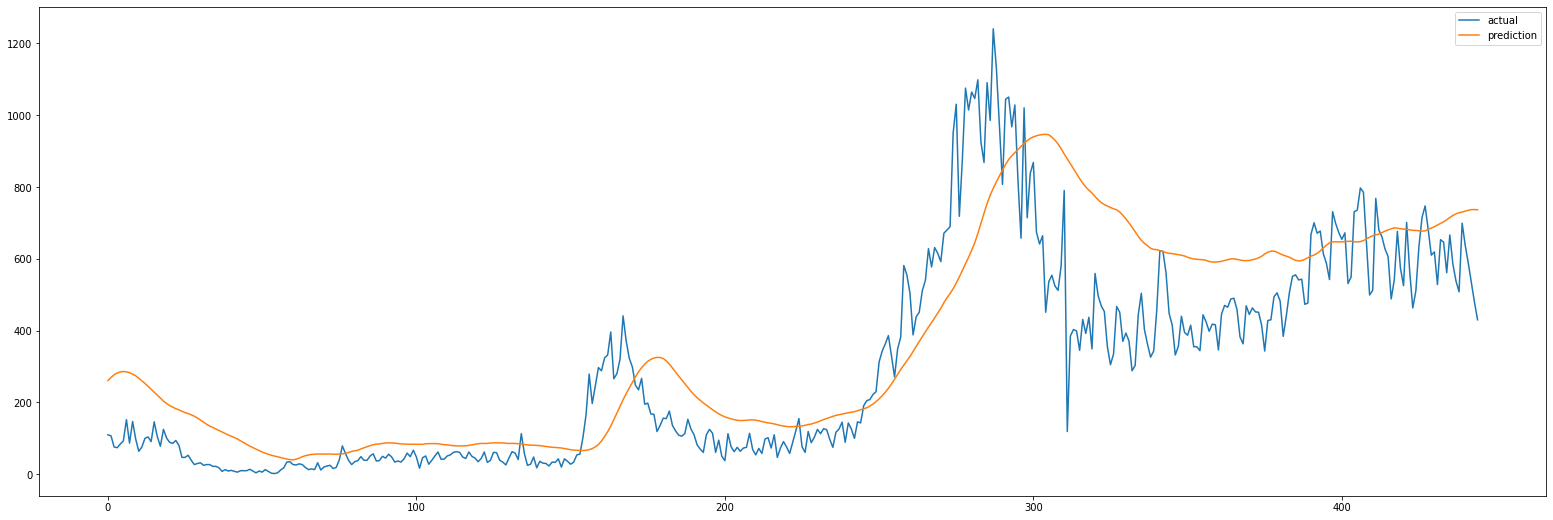

In [20]:
import matplotlib.pyplot as plt

# loading weight
model.load_weights('check.h5')

# prediction
pred_all = model.predict(test_feature_all)

inverse_test_label_all = scaler_test.inverse_transform(test_label_all)
inverse_test_label_all = pd.DataFrame(inverse_test_label_all)

inverse_pred_all = scaler_test.inverse_transform(pred_all)
inverse_pred_all = pd.DataFrame(inverse_pred_all)

plt.figure(figsize = (27, 9))
plt.plot(inverse_test_label_all, label = 'actual')
plt.plot(inverse_pred_all, label = 'prediction')
plt.legend()
plt.show()

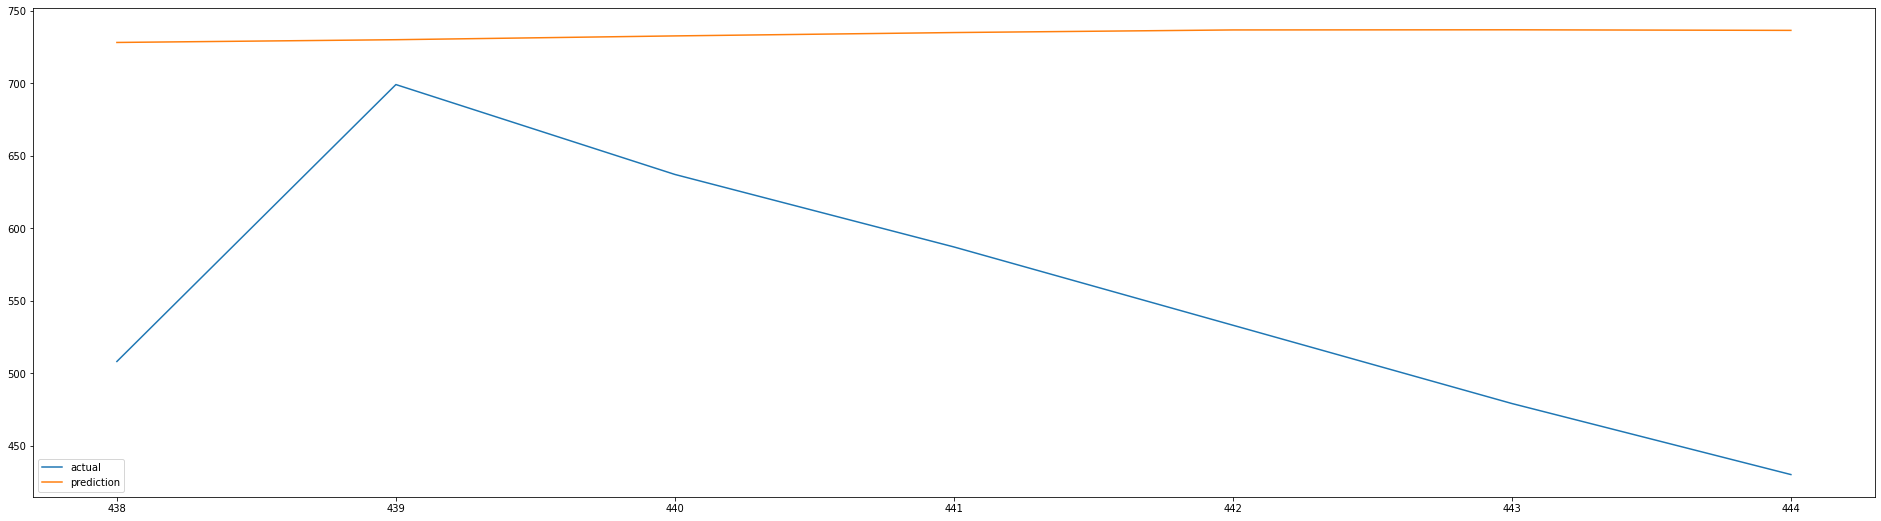

In [21]:
plt.figure(figsize = (33, 9))
plt.plot(inverse_test_label_all[len(inverse_test_label_all) - 7:], label = 'actual')
plt.plot(inverse_pred_all[len(inverse_pred_all) - 7:], label = 'prediction')
plt.legend()
plt.show()

# 도별 데이터를 하나씩 분리해서 3차원 배열 구성
# 감염자 요소 하나만으로 학습할 시 데이터 양: 약 4000개(1x400x10)
# 여러가지 요소로 학습할 시 데이터 양: 20000개(5x400x10)
# 데이터 부족으로 인한 낮은 적중률 해결

In [22]:
data_all_origin = pd.read_csv(cp + '/all/covid19_20210524_all.csv')
data_part_origin = pd.read_csv(cp + '/part/covid19_20210524_part.csv')

data_all = data_all_origin.drop(['Unnamed: 0'], axis = 1)
data_part = data_part_origin.drop(['Unnamed: 0'], axis = 1)

In [23]:
data_part.isnull().sum()

createDt           0
deathCnt           0
defCnt            19
gubun              0
gubunCn          293
gubunEn          292
incDec             0
isolClearCnt     109
isolIngCnt       691
localOccCnt      691
overFlowCnt      691
qurRate           19
seq                0
stdDay             0
updateDt        8237
dtype: int64

In [24]:
data_part

,createDt,deathCnt,defCnt,gubun,gubunCn,gubunEn,incDec,isolClearCnt,isolIngCnt,localOccCnt,overFlowCnt,qurRate,seq,stdDay,updateDt
0,27:57.6,0,NaN,검역,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,19,20200301,04:50.5
1,27:57.6,0,NaN,제주,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,18,20200301,NaN
2,27:57.6,0,NaN,경남,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,17,20200301,NaN
3,27:57.6,8,NaN,경북,NaN,NaN,67,NaN,NaN,NaN,NaN,NaN,16,20200301,NaN
4,27:57.6,0,NaN,전남,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,15,20200301,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8505,2021-05-24 09:46:24.358,124,5555.0,부산,釜山,Busan,15,5169.0,262.0,14.0,1.0,162.82,9700,20210524,NaN
8506,2021-05-24 09:46:24.358,480,42601.0,서울,首尔,Seoul,139,39276.0,2845.0,136.0,3.0,437.67,9699,20210524,NaN
8507,2021-05-24 09:46:24.358,1934,136467.0,합계,合计,Total,538,126427.0,8106.0,513.0,25.0,263.21,9698,20210524,NaN
8508,2021-05-24 09:46:24.36,628,38008.0,경기,京畿,Gyeonggi-do,122,35278.0,2102.0,120.0,2.0,286.84,9707,20210524,NaN


In [25]:
data_part = data_part.drop(['updateDt', 'createDt', 'gubunCn', 'deathCnt',
                            'seq','incDec', 'qurRate', 'overFlowCnt', 'localOccCnt'], axis = 1)
data_part = data_part.dropna(axis = 0)

data_part.isnull().sum()

defCnt          0
gubun           0
gubunEn         0
isolClearCnt    0
isolIngCnt      0
stdDay          0
dtype: int64

In [26]:
GSND = data_part.loc[(data_part['gubunEn'] == 'Gyeongsangnam-do')].reset_index(drop = True)
GSBD = data_part.loc[(data_part['gubunEn'] == 'Gyeongsangbuk-do')].reset_index(drop = True)
JLND = data_part.loc[(data_part['gubunEn'] == 'Jeollanam-do')].reset_index(drop = True)
JLBD = data_part.loc[(data_part['gubunEn'] == 'Jeollabuk-do')].reset_index(drop = True)
CCND = data_part.loc[(data_part['gubunEn'] == 'Chungcheongnam-do')].reset_index(drop = True)
CCBD = data_part.loc[(data_part['gubunEn'] == 'Chungcheongbuk-do')].reset_index(drop = True)
Gangwon = data_part.loc[(data_part['gubunEn'] == 'Gangwon-do')].reset_index(drop = True)
Gyeonggi = data_part.loc[(data_part['gubunEn'] == 'Gyeonggi-do')].reset_index(drop = True)
Incheon = data_part.loc[(data_part['gubunEn'] == 'Incheon')].reset_index(drop = True)
Daegu = data_part.loc[(data_part['gubunEn'] == 'Daegu')].reset_index(drop = True)
Busan = data_part.loc[(data_part['gubunEn'] == 'Busan')].reset_index(drop = True)
Seoul = data_part.loc[(data_part['gubunEn'] == 'Seoul')].reset_index(drop = True)

In [27]:
GSND = GSND.drop(['gubun', 'gubunEn', 'isolIngCnt', 'stdDay'], axis = 1)
GSBD = GSBD.drop(['gubun', 'gubunEn', 'isolIngCnt', 'stdDay'], axis = 1)
JLND = JLND.drop(['gubun', 'gubunEn', 'isolIngCnt', 'stdDay'], axis = 1)
JLBD = JLBD.drop(['gubun', 'gubunEn', 'isolIngCnt', 'stdDay'], axis = 1)
CCND = CCND.drop(['gubun', 'gubunEn', 'isolIngCnt', 'stdDay'], axis = 1)
CCBD = CCBD.drop(['gubun', 'gubunEn', 'isolIngCnt', 'stdDay'], axis = 1)
Gangwon = Gangwon.drop(['gubun', 'gubunEn', 'isolIngCnt', 'stdDay'], axis = 1)
Gyeonggi = Gyeonggi.drop(['gubun', 'gubunEn', 'isolIngCnt', 'stdDay'], axis = 1)
Incheon = Incheon.drop(['gubun', 'gubunEn', 'isolIngCnt', 'stdDay'], axis = 1)
Daegu = Daegu.drop(['gubun', 'gubunEn', 'isolIngCnt', 'stdDay'], axis = 1)
Busan = Busan.drop(['gubun', 'gubunEn', 'isolIngCnt', 'stdDay'], axis = 1)
Seoul = Seoul.drop(['gubun', 'gubunEn', 'isolIngCnt', 'stdDay'], axis = 1)

In [28]:
# 데이터셋을 합치기 위해 shape맞추기
# shape가 다른 데이터셋 목록
# JLBD, CCND, CCBD
GSND = GSND.drop([0], axis = 0).reset_index(drop = True)
GSBD = GSBD.drop([0], axis = 0).reset_index(drop = True)
JLND = JLND.drop([0], axis = 0).reset_index(drop = True)
JLBD = JLBD.drop([0], axis = 0).reset_index(drop = True)
Gangwon = Gangwon.drop([0], axis = 0).reset_index(drop = True)
Gyeonggi = Gyeonggi.drop([0], axis = 0).reset_index(drop = True)
Incheon = Incheon.drop([0], axis = 0).reset_index(drop = True)
Daegu = Daegu.drop([0], axis = 0).reset_index(drop = True)
Busan = Busan.drop([0], axis = 0).reset_index(drop = True)
Seoul = Seoul.drop([0], axis = 0).reset_index(drop = True)

In [29]:
infector_GSND = []
clear_GSND = []
infector_GSND.append(0)
clear_GSND.append(0)

infector_GSBD = []
clear_GSBD = []
infector_GSBD.append(0)
clear_GSBD.append(0)

infector_JLND = []
clear_JLND = []
infector_JLND.append(0)
clear_JLND.append(0)

infector_JLBD = []
clear_JLBD = []
infector_JLBD.append(0)
clear_JLBD.append(0)

infector_Gangwon = []
clear_Gangwon = []
infector_Gangwon.append(0)
clear_Gangwon.append(0)

infector_Gyeonggi = []
clear_Gyeonggi = []
infector_Gyeonggi.append(0)
clear_Gyeonggi.append(0)

infector_Incheon = []
clear_Incheon = []
infector_Incheon.append(0)
clear_Incheon.append(0)

infector_Daegu = []
clear_Daegu = []
infector_Daegu.append(0)
clear_Daegu.append(0)

infector_Busan = []
clear_Busan = []
infector_Busan.append(0)
clear_Busan.append(0)

infector_Seoul = []
clear_Seoul = []
infector_Seoul.append(0)
clear_Seoul.append(0)

for i in range(len(GSND) - 1):
    infector_GSND.append(GSND['defCnt'][i + 1] - GSND['defCnt'][i])
    clear_GSND.append(GSND['isolClearCnt'][i + 1] - GSND['isolClearCnt'][i])
for i in range(len(GSBD) - 1):
    infector_GSBD.append(GSBD['defCnt'][i + 1] - GSBD['defCnt'][i])
    clear_GSBD.append(GSBD['isolClearCnt'][i + 1] - GSBD['isolClearCnt'][i])
for i in range(len(JLND) - 1):
    infector_JLND.append(JLND['defCnt'][i + 1] - JLND['defCnt'][i])
    clear_JLND.append(JLND['isolClearCnt'][i + 1] - JLND['isolClearCnt'][i])
for i in range(len(JLBD) - 1):
    infector_JLBD.append(JLBD['defCnt'][i + 1] - JLBD['defCnt'][i])
    clear_JLBD.append(JLBD['isolClearCnt'][i + 1] - JLBD['isolClearCnt'][i])
for i in range(len(Gangwon) - 1):
    infector_Gangwon.append(Gangwon['defCnt'][i + 1] - Gangwon['defCnt'][i])
    clear_Gangwon.append(Gangwon['isolClearCnt'][i + 1] - Gangwon['isolClearCnt'][i])
for i in range(len(Gyeonggi) - 1):
    infector_Gyeonggi.append(Gyeonggi['defCnt'][i + 1] - Gyeonggi['defCnt'][i])
    clear_Gyeonggi.append(Gyeonggi['isolClearCnt'][i + 1] - Gyeonggi['isolClearCnt'][i])
for i in range(len(Incheon) - 1):
    infector_Incheon.append(Incheon['defCnt'][i + 1] - Incheon['defCnt'][i])
    clear_Incheon.append(Incheon['isolClearCnt'][i + 1] - Incheon['isolClearCnt'][i])
for i in range(len(Daegu) - 1):
    infector_Daegu.append(Daegu['defCnt'][i + 1] - Daegu['defCnt'][i])
    clear_Daegu.append(Daegu['isolClearCnt'][i + 1] - Daegu['isolClearCnt'][i])
for i in range(len(Busan) - 1):
    infector_Busan.append(Busan['defCnt'][i + 1] - Busan['defCnt'][i])
    clear_Busan.append(Busan['isolClearCnt'][i + 1] - Busan['isolClearCnt'][i])
for i in range(len(Seoul) - 1):
    infector_Seoul.append(Seoul['defCnt'][i + 1] - Seoul['defCnt'][i])
    clear_Seoul.append(Seoul['isolClearCnt'][i + 1] - Seoul['isolClearCnt'][i])

infector_GSND = np.array(infector_GSND)
infector_GSND = pd.DataFrame(infector_GSND)
infector_GSND.columns = ['infector']
clear_GSND = np.array(clear_GSND)
clear_GSND = pd.DataFrame(clear_GSND)
clear_GSND.columns = ['clear']

infector_GSBD = np.array(infector_GSBD)
infector_GSBD = pd.DataFrame(infector_GSBD)
infector_GSBD.columns = ['infector']
clear_GSBD = np.array(clear_GSBD)
clear_GSBD = pd.DataFrame(clear_GSBD)
clear_GSBD.columns = ['clear']

infector_JLND = np.array(infector_JLND)
infector_JLND = pd.DataFrame(infector_JLND)
infector_JLND.columns = ['infector']
clear_JLND = np.array(clear_JLND)
clear_JLND = pd.DataFrame(clear_JLND)
clear_JLND.columns = ['clear']

infector_JLBD = np.array(infector_JLBD)
infector_JLBD = pd.DataFrame(infector_JLBD)
infector_JLBD.columns = ['infector']
clear_JLBD = np.array(clear_JLBD)
clear_JLBD = pd.DataFrame(clear_JLBD)
clear_JLBD.columns = ['clear']

infector_Gangwon = np.array(infector_Gangwon)
infector_Gangwon = pd.DataFrame(infector_Gangwon)
infector_Gangwon.columns = ['infector']
clear_Gangwon = np.array(clear_Gangwon)
clear_Gangwon = pd.DataFrame(clear_Gangwon)
clear_Gangwon.columns = ['clear']

infector_Gyeonggi = np.array(infector_Gyeonggi)
infector_Gyeonggi = pd.DataFrame(infector_Gyeonggi)
infector_Gyeonggi.columns = ['infector']
clear_Gyeonggi = np.array(clear_Gyeonggi)
clear_Gyeonggi = pd.DataFrame(clear_Gyeonggi)
clear_Gyeonggi.columns = ['clear']

infector_Incheon = np.array(infector_Incheon)
infector_Incheon = pd.DataFrame(infector_Incheon)
infector_Incheon.columns = ['infector']
clear_Incheon = np.array(clear_Incheon)
clear_Incheon = pd.DataFrame(clear_Incheon)
clear_Incheon.columns = ['clear']

infector_Daegu = np.array(infector_Daegu)
infector_Daegu = pd.DataFrame(infector_Daegu)
infector_Daegu.columns = ['infector']
clear_Daegu = np.array(clear_Daegu)
clear_Daegu = pd.DataFrame(clear_Daegu)
clear_Daegu.columns = ['clear']

infector_Busan = np.array(infector_Busan)
infector_Busan = pd.DataFrame(infector_Busan)
infector_Busan.columns = ['infector']
clear_Busan = np.array(clear_Busan)
clear_Busan = pd.DataFrame(clear_Busan)
clear_Busan.columns = ['clear']

infector_Seoul = np.array(infector_Seoul)
infector_Seoul = pd.DataFrame(infector_Seoul)
infector_Seoul.columns = ['infector']
clear_Seoul = np.array(clear_Seoul)
clear_Seoul = pd.DataFrame(clear_Seoul)
clear_Seoul.columns = ['clear']

GSND = GSND.assign(infector = infector_GSND)
GSND = GSND.assign(clear = clear_GSND)
GSND = GSND.drop(['defCnt', 'isolClearCnt'], axis = 1)

GSBD = GSBD.assign(infector = infector_GSBD)
GSBD = GSBD.assign(clear = clear_GSBD)
GSBD = GSBD.drop(['defCnt', 'isolClearCnt'], axis = 1)

JLND = JLND.assign(infector = infector_JLND)
JLND = JLND.assign(clear = clear_JLND)
JLND = JLND.drop(['defCnt', 'isolClearCnt'], axis = 1)

JLBD = JLBD.assign(infector = infector_JLBD)
JLBD = JLBD.assign(clear = clear_JLBD)
JLBD = JLBD.drop(['defCnt', 'isolClearCnt'], axis = 1)

Gangwon = Gangwon.assign(infector = infector_Gangwon)
Gangwon = Gangwon.assign(clear = clear_Gangwon)
Gangwon = Gangwon.drop(['defCnt', 'isolClearCnt'], axis = 1)

Gyeonggi = Gyeonggi.assign(infector = infector_Gyeonggi)
Gyeonggi = Gyeonggi.assign(clear = clear_Gyeonggi)
Gyeonggi = Gyeonggi.drop(['defCnt', 'isolClearCnt'], axis = 1)

Incheon = Incheon.assign(infector = infector_Incheon)
Incheon = Incheon.assign(clear = clear_Incheon)
Incheon = Incheon.drop(['defCnt', 'isolClearCnt'], axis = 1)

Daegu = Daegu.assign(infector = infector_Daegu)
Daegu = Daegu.assign(clear = clear_Daegu)
Daegu = Daegu.drop(['defCnt', 'isolClearCnt'], axis = 1)

Busan = Busan.assign(infector = infector_Busan)
Busan = Busan.assign(clear = clear_Busan)
Busan = Busan.drop(['defCnt', 'isolClearCnt'], axis = 1)

Seoul = Seoul.assign(infector = infector_Seoul)
Seoul = Seoul.assign(clear = clear_Seoul)
Seoul = Seoul.drop(['defCnt', 'isolClearCnt'], axis = 1)

In [30]:
data_part_stack = np.stack((GSND, GSBD, JLND, JLBD, Gangwon, Gyeonggi, Incheon, Daegu, Busan, Seoul))
data_sample = data_part_stack.shape[0] # 샘플 데이터 수(z축)
data_sequence = data_part_stack.shape[1] # 데이터 수(y축)
data_feature = data_part_stack.shape[2] # 속성 수(x축)
data_sample, data_sequence, data_feature

(10, 411, 2)

In [31]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

for i in range(data_sequence):
    s = scaler.partial_fit(data_part_stack[:, i, :])

results = []
for i in range(data_sequence):
    results.append(scaler.transform(data_part_stack[:, i, :]).reshape(data_sample, 1, data_feature))
scaled_data_part_stack = np.concatenate(results, axis = 1)

train_label = data_part_stack[:, :, 1]
train_label = scaler.fit_transform(train_label)
train_label = np.array(train_label)

In [32]:
train_feature = scaled_data_part_stack
train_feature.shape, train_label.shape

((10, 411, 2), (10, 411))

In [33]:
# make dataset
# find next 'end' data 
def make_dataset(data, label, window_size = 10):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i + window_size]))
        label_list.append(np.array(label.iloc[i + window_size]))
    return np.array(feature_list), np.array(label_list)
# dataset: (i ~ i + window_size)days feature_list and (i + window_size) label_list
# 10개의 데이터에 그 다음날 결과 값이 한 세트

In [34]:
# make dataset
# find next 'end' data 
def make_feature_dataset(data, window_size = 10):
    feature_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data[i:i + window_size]))
    return np.array(feature_list)
# dataset: (i ~ i + window_size)days feature_list and (i + window_size) label_list
# 10개의 데이터에 그 다음날 결과 값이 한 세트

In [35]:
# make dataset
# find next 'end' data 
def make_label_dataset(label, window_size = 10):
    label_list = []
    for i in range(len(label) - window_size):
        label_list.append(np.array(label[i + window_size]))
    return np.array(label_list)
# dataset: (i ~ i + window_size)days feature_list and (i + window_size) label_list
# 10개의 데이터에 그 다음날 결과 값이 한 세트

In [36]:
feature_part = []
for i in range(data_sample):
    feature_part.append(make_feature_dataset(train_feature[i][:][:], 10))

train_feature = np.stack((feature_part[0:10]))
train_feature.shape

(10, 401, 10, 2)

In [38]:
label_part = []
for i in range(data_sample):
    label_part.append(make_label_dataset(train_label[i][:], 10))
    
train_label.shape

(10, 411)

# 4차원으로 나오는데 RNN은 4차원을 지원 안하므로 잠시 중단